# SVM with SMO

In [6]:
from __future__ import division, print_function
from tqdm import tqdm_notebook as tqdm
import os
import numpy as np
import random as rnd

In [7]:
class SVM():
    def __init__(self, max_iter=10000, kernel_type='linear', C=1.0, epsilon=0.001, sigma=.01):
        self.kernels = {
            'linear' : self.kernel_linear,
            'quadratic' : self.kernel_quadratic,
            'rbf': self.kernel_rbf
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.epsilon = epsilon
        self.sigma = sigma

    def fit(self, X, y):
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        kernel = self.kernels[self.kernel_type]
        count = 0
        pbar = tqdm(total=100)
        while True:
            count += 1
            alpha_prev = np.copy(alpha)
            for j in (range(0, n)):
                i = self.get_rnd_int(0, n-1, j)
                x_i, x_j, y_i, y_j = X[i], X[j], y[i], y[j]
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

            diff = np.linalg.norm(alpha - alpha_prev)
            prog = int(100/2.718**(diff*100))
            print(count, diff, prog)
            pbar.n = prog
            pbar.update(0)
            if diff < self.epsilon:
                break

            if count >= self.max_iter:
                return
        self.b = self.calc_b(X, y, self.w)
        alpha_idx = np.where(alpha > 0)[0]
        support_vectors = X[alpha_idx, :]
        return support_vectors, count
    def predict(self, X):
        return self.h(X, self.w, self.b)
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    def calc_w(self, alpha, y, X):
        return np.dot(X.T, np.multiply(alpha,y))

    def h(self, X, w, b):
#         return np.sign(self.kernels[self.kernel_type](w.T, X.T) + b).astype(int)
        return np.sign(np.dot(w.T, X.T) + b).astype(int)
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))
    def get_rnd_int(self, a,b,z):
        i = z
        while i == z:
            i = rnd.randint(a,b)
        return i
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)
    def kernel_quadratic(self, x1, x2):
        return (np.dot(x1, x2.T) ** 2)
    def kernel_rbf(self, x1, x2):
        return np.exp(-np.linalg.norm(x1 - x2)**2/(2 * self.sigma**2))
#         return np.exp(-((x1 - x2).dot((x1 - x2).T)/(2 * self.sigma**2)))

In [8]:
import csv, os, sys

def readData(filename, header=True):
    data, header = [], None
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        if header:
            header = reader.next()
        for row in reader:
            if row[0] == '3' or row[0] == '8':
                row[0] = 1 if row[0] == '3' else -1
                data.append(row)
    return (np.array(data), np.array(header))

def calc_acc(y, y_hat):
    idx = np.where(y_hat == 1)
    TP = np.sum(y_hat[idx] == y[idx])
    idx = np.where(y_hat == -1)
    TN = np.sum(y_hat[idx] == y[idx])
    return float(TP + TN)/len(y)

In [9]:
filename = 'mnist.csv'
split = .07
# Load data
(data, _) = readData('%s' % (filename), header=False)
data = data.astype(float)
data[:,1:] /= 255
idx = round(len(data)*split)
train_x, train_y, test_x, test_y = data[:idx,1:], data[:idx,0].astype(int), data[idx:,1:], data[idx:,0].astype(int)
print(f'{train_x.shape} vs {test_x.shape}')

(839, 784) vs (11143, 784)


In [22]:
C = 1
kernel_type = 'rbf'
epsilon = 1e-3
sigma = 1

model = SVM(C=C, kernel_type=kernel_type, epsilon=epsilon, sigma=sigma)
support_vectors, iterations = model.fit(train_x, train_y)
sv_count = support_vectors.shape[0]
y_hat = model.predict(train_x)
acc = calc_acc(train_y, y_hat)
print("training accuracy:\t%.3f" % (acc))

/home/dedsec/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: overflow encountered in double_scalars


1 9.38083151964686 0
2 6.324555320336759 0
3 2.8284271247461903 0
4 2.0 0
5 2.0 0
6 0.0 100
training accuracy:	0.975


In [23]:
y_hat = model.predict(test_x)
acc = calc_acc(test_y, y_hat)
print("testing accuracy:\t%.3f" % (acc))

testing accuracy:	0.949


In [24]:
# ROC stuff: GG Nitin
TPR = []
FPR = []
for t in tqdm(range(-100,100,1)):
    y_pre1 = (np.dot(model.w.T, test_x.T) + model.b)
    for i in range(len(y_pre1)):
        if y_pre1[i] >= t:
            y_pre1[i] = 1
        else:
            y_pre1[i] = -1
    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(len(y_pre1)):
        if y_pre1[i] == 1:
            if test_y[i] == y_pre1[i]:
                TP += 1
            else:
                FP += 1
        else:
            if test_y[i] == y_pre1[i]:
                TN += 1
            else:
                FN += 1
    TPR.append(TP/(TP+FN))
    FPR.append(FP/(FP+TN))
TPR = np.array(TPR)
FPR = np.array(FPR)


<h3>Linear Kernel ROC</h3>

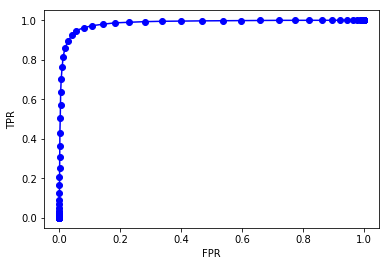

In [21]:
import matplotlib.pyplot as plt
plt.plot(FPR,TPR,'-bo')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

<h3>Quadratic Kernel ROC</h3>

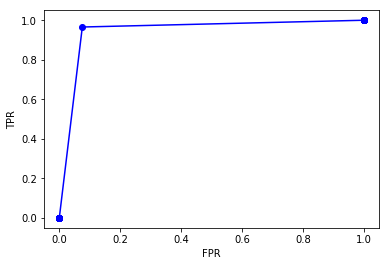

In [14]:
import matplotlib.pyplot as plt
plt.plot(FPR,TPR,'-bo')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

<h3>RBF Kernel ROC</h3>

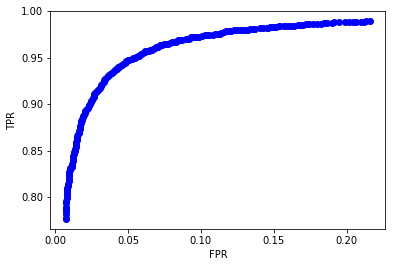

In [25]:
import matplotlib.pyplot as plt
plt.plot(FPR,TPR,'-bo')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [18]:
# Fuzzy Addition Example: GG Charan
A = [(2, 0.5), (3, 1)]
B = [(3, 0.5), (4, 0.75)]
def get(a, b):
    val = a[0] + b[0]
    prob = min(a[1], b[1])
    return val, prob

dt = {}  
for i in range(len(A)):
    for j in range(len(B)):
        val, prob = get(A[i], B[j])
        if val in dt:
            if dt[val] < prob:
                dt[val] = prob
        else:
            dt[val] = prob
for x in dt:
    print(x,dt[x])

5 0.5
6 0.5
7 0.75
